In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [14]:
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Image batch shape: torch.Size([64, 1, 28, 28])


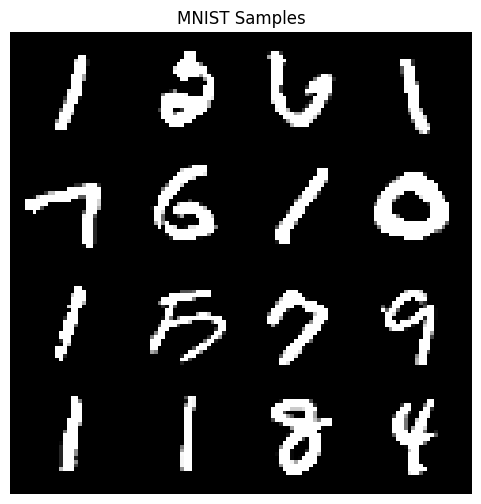

In [15]:

import torchvision
images, labels = next(iter(train_loader))

print("Image batch shape:", images.shape)
# Make a grid of images
img_grid = torchvision.utils.make_grid(images[:16], nrow=4)

# Convert from tensor to numpy
plt.figure(figsize=(6,6))
plt.imshow(img_grid.permute(1, 2, 0), cmap="gray")
plt.axis("off")
plt.title("MNIST Samples")
plt.show()

Training & Evaluation

In [16]:
def train_model(model, optimizer, criterion, epochs):
    train_acc, val_acc = [], []
    train_loss, val_loss = [], []

    for epoch in range(epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == target).sum().item()
            total += target.size(0)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = correct / total

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)

        model.eval()
        correct, total, running_loss = 0, 0, 0.0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                running_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == target).sum().item()
                total += target.size(0)

        epoch_val_loss = running_loss / len(test_loader)
        epoch_val_acc = correct / total

        val_loss.append(epoch_val_loss)
        val_acc.append(epoch_val_acc)

        print(
            f"Epoch [{epoch+1}/{epochs}] | "
            f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}"
        )

    return train_acc, val_acc, train_loss, val_loss


Plot Training Curves

In [17]:
def plot_curves(train_acc, test_acc, train_loss, test_loss, title):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(test_acc, label="Test Acc")
    plt.title(title + " Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(test_loss, label="Test Loss")
    plt.title(title + " Loss")
    plt.legend()

    plt.show()


CNN Model (Base Architecture)

In [18]:
class CNN(nn.Module):
    def __init__(self, activation=nn.ReLU, dropout=0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3),
            activation(),
            nn.Conv2d(32, 64, 3),
            activation(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            activation(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Task 1 – Activation Function Comparison



### Task 1: Activation Function Comparison
- Sigmoid
- Tanh
- ReLU

Observation:
- Sigmoid converges slowly due to vanishing gradient problem.
- Tanh performs better than Sigmoid but still slower than ReLU.
- ReLU converges fastest and gives better accuracy.

Sigmoid

Epoch [1/10] | Train Loss: 2.2980, Train Acc: 0.1191 | Val Loss: 2.2874, Val Acc: 0.1010
Epoch [2/10] | Train Loss: 2.2459, Train Acc: 0.2470 | Val Loss: 2.1369, Val Acc: 0.4009
Epoch [3/10] | Train Loss: 1.5930, Train Acc: 0.6462 | Val Loss: 0.9741, Val Acc: 0.7870
Epoch [4/10] | Train Loss: 0.7475, Train Acc: 0.8214 | Val Loss: 0.5674, Val Acc: 0.8606
Epoch [5/10] | Train Loss: 0.5162, Train Acc: 0.8666 | Val Loss: 0.4406, Val Acc: 0.8877
Epoch [6/10] | Train Loss: 0.4289, Train Acc: 0.8819 | Val Loss: 0.3816, Val Acc: 0.8944
Epoch [7/10] | Train Loss: 0.3836, Train Acc: 0.8911 | Val Loss: 0.3455, Val Acc: 0.9035
Epoch [8/10] | Train Loss: 0.3536, Train Acc: 0.8962 | Val Loss: 0.3222, Val Acc: 0.9074
Epoch [9/10] | Train Loss: 0.3318, Train Acc: 0.9030 | Val Loss: 0.3069, Val Acc: 0.9102
Epoch [10/10] | Train Loss: 0.3147, Train Acc: 0.9067 | Val Loss: 0.2936, Val Acc: 0.9143


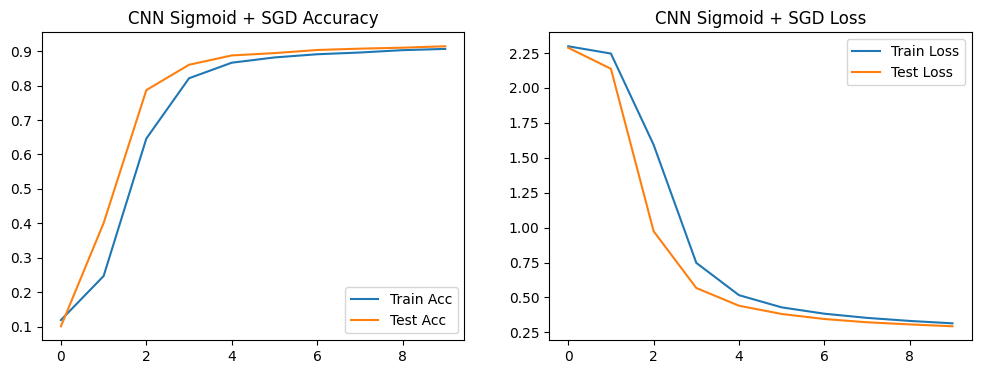

In [19]:
model_sigmoid = CNN(activation=nn.Sigmoid).to(device)
optimizer = optim.SGD(model_sigmoid.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

sig_tr_acc, sig_val_acc, sig_tr_loss, sig_val_loss = train_model(model_sigmoid, optimizer, criterion, 10)
plot_curves(sig_tr_acc, sig_val_acc, sig_tr_loss, sig_val_loss, "CNN Sigmoid + SGD")

Tanh

Epoch [1/10] | Train Loss: 0.4860, Train Acc: 0.8779 | Val Loss: 0.2576, Val Acc: 0.9261
Epoch [2/10] | Train Loss: 0.2349, Train Acc: 0.9327 | Val Loss: 0.1905, Val Acc: 0.9460
Epoch [3/10] | Train Loss: 0.1792, Train Acc: 0.9487 | Val Loss: 0.1515, Val Acc: 0.9566
Epoch [4/10] | Train Loss: 0.1445, Train Acc: 0.9591 | Val Loss: 0.1242, Val Acc: 0.9645
Epoch [5/10] | Train Loss: 0.1200, Train Acc: 0.9666 | Val Loss: 0.1074, Val Acc: 0.9706
Epoch [6/10] | Train Loss: 0.1021, Train Acc: 0.9714 | Val Loss: 0.0932, Val Acc: 0.9753
Epoch [7/10] | Train Loss: 0.0884, Train Acc: 0.9766 | Val Loss: 0.0811, Val Acc: 0.9761
Epoch [8/10] | Train Loss: 0.0777, Train Acc: 0.9793 | Val Loss: 0.0717, Val Acc: 0.9789
Epoch [9/10] | Train Loss: 0.0691, Train Acc: 0.9810 | Val Loss: 0.0655, Val Acc: 0.9807
Epoch [10/10] | Train Loss: 0.0622, Train Acc: 0.9836 | Val Loss: 0.0620, Val Acc: 0.9820


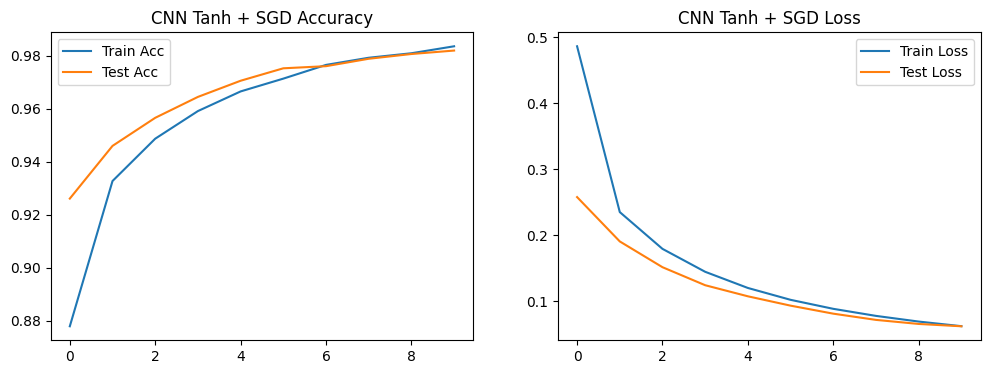

In [20]:
model_tanh = CNN(activation=nn.Tanh).to(device)
optimizer = optim.SGD(model_tanh.parameters(), lr=0.01)

tanh_tr_acc, tanh_val_acc, tanh_tr_loss, tanh_val_loss = train_model(model_tanh, optimizer, criterion, 10)
plot_curves(tanh_tr_acc, tanh_val_acc, tanh_tr_loss, tanh_val_loss, "CNN Tanh + SGD")

ReLU

Epoch [1/10] | Train Loss: 0.4368, Train Acc: 0.8747 | Val Loss: 0.1906, Val Acc: 0.9455
Epoch [2/10] | Train Loss: 0.1655, Train Acc: 0.9508 | Val Loss: 0.1004, Val Acc: 0.9700
Epoch [3/10] | Train Loss: 0.1054, Train Acc: 0.9688 | Val Loss: 0.0760, Val Acc: 0.9765
Epoch [4/10] | Train Loss: 0.0787, Train Acc: 0.9776 | Val Loss: 0.0579, Val Acc: 0.9821
Epoch [5/10] | Train Loss: 0.0628, Train Acc: 0.9811 | Val Loss: 0.0563, Val Acc: 0.9826
Epoch [6/10] | Train Loss: 0.0532, Train Acc: 0.9844 | Val Loss: 0.0456, Val Acc: 0.9862
Epoch [7/10] | Train Loss: 0.0467, Train Acc: 0.9860 | Val Loss: 0.0419, Val Acc: 0.9862
Epoch [8/10] | Train Loss: 0.0403, Train Acc: 0.9878 | Val Loss: 0.0396, Val Acc: 0.9865
Epoch [9/10] | Train Loss: 0.0359, Train Acc: 0.9893 | Val Loss: 0.0367, Val Acc: 0.9875
Epoch [10/10] | Train Loss: 0.0327, Train Acc: 0.9901 | Val Loss: 0.0320, Val Acc: 0.9895


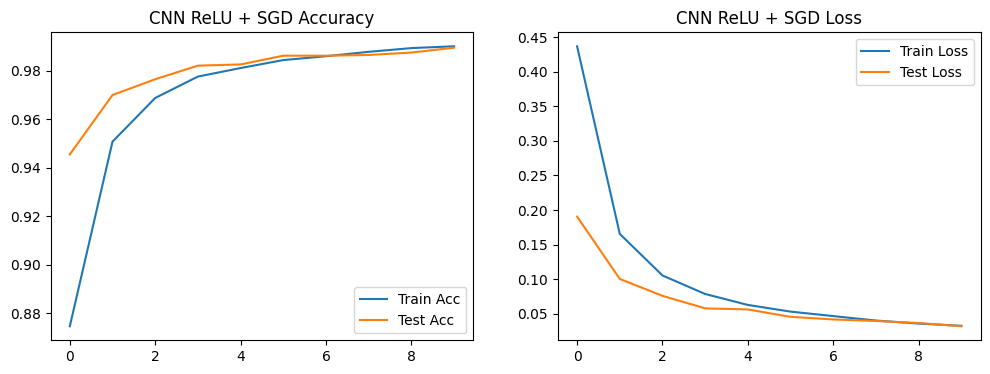

In [21]:
model_relu = CNN(activation=nn.ReLU).to(device)
optimizer = optim.SGD(model_relu.parameters(), lr=0.01)

relu_tr_acc, relu_val_acc, relu_tr_loss, relu_val_loss = train_model(model_relu, optimizer, criterion, 10)
plot_curves(relu_tr_acc, relu_val_acc, relu_tr_loss, relu_val_loss, "CNN ReLU + SGD")


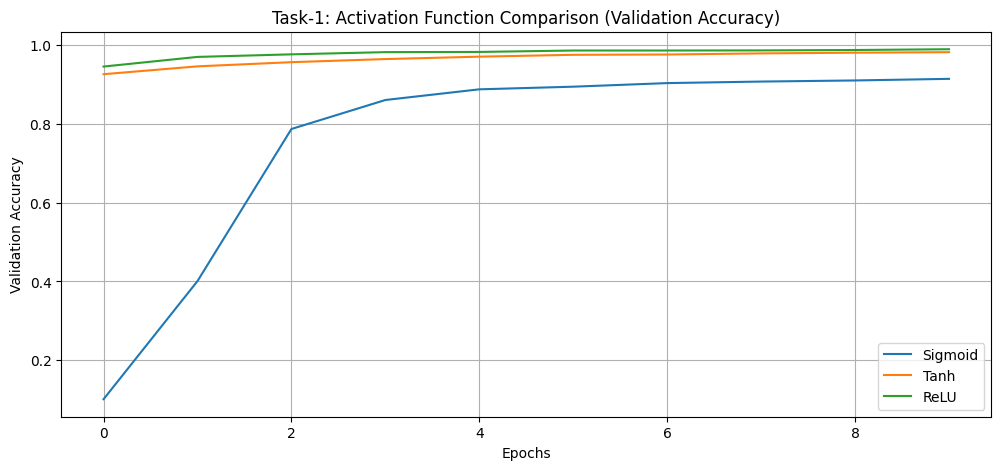

In [22]:
plt.figure(figsize=(12,5))

plt.plot(sig_val_acc, label="Sigmoid")
plt.plot(tanh_val_acc, label="Tanh")
plt.plot(relu_val_acc, label="ReLU")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Task-1: Activation Function Comparison (Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


#Task 2 – Optimizer Comparison (ReLU Fixed)

### Task 2: Optimizer Comparison
- SGD
- SGD with Momentum
- Adam

Observation:
- SGD is slow and unstable.
- Momentum improves convergence stability.
- Adam reaches high accuracy fastest.

In [23]:
criterion = nn.CrossEntropyLoss()
epochs = 10

SGD

In [24]:
model_sgd = CNN(activation=nn.ReLU).to(device)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

print("\nTraining with SGD\n")
sgd_tr_acc, sgd_val_acc, sgd_tr_loss, sgd_val_loss = train_model(
    model_sgd, optimizer_sgd, criterion, epochs
)



Training with SGD

Epoch [1/10] | Train Loss: 0.4222, Train Acc: 0.8777 | Val Loss: 0.1889, Val Acc: 0.9431
Epoch [2/10] | Train Loss: 0.1715, Train Acc: 0.9478 | Val Loss: 0.1356, Val Acc: 0.9594
Epoch [3/10] | Train Loss: 0.1160, Train Acc: 0.9650 | Val Loss: 0.0905, Val Acc: 0.9722
Epoch [4/10] | Train Loss: 0.0893, Train Acc: 0.9734 | Val Loss: 0.0729, Val Acc: 0.9766
Epoch [5/10] | Train Loss: 0.0723, Train Acc: 0.9781 | Val Loss: 0.0592, Val Acc: 0.9826
Epoch [6/10] | Train Loss: 0.0608, Train Acc: 0.9814 | Val Loss: 0.0517, Val Acc: 0.9839
Epoch [7/10] | Train Loss: 0.0529, Train Acc: 0.9835 | Val Loss: 0.0501, Val Acc: 0.9832
Epoch [8/10] | Train Loss: 0.0465, Train Acc: 0.9857 | Val Loss: 0.0498, Val Acc: 0.9842
Epoch [9/10] | Train Loss: 0.0423, Train Acc: 0.9872 | Val Loss: 0.0414, Val Acc: 0.9862
Epoch [10/10] | Train Loss: 0.0371, Train Acc: 0.9886 | Val Loss: 0.0377, Val Acc: 0.9871


SGD + Momentum

In [25]:
model_momentum = CNN(activation=nn.ReLU).to(device)
optimizer_momentum = optim.SGD(
    model_momentum.parameters(),
    lr=0.01,
    momentum=0.9
)

print("\nTraining with SGD + Momentum\n")
mom_tr_acc, mom_val_acc, mom_tr_loss, mom_val_loss = train_model(
    model_momentum, optimizer_momentum, criterion, epochs
)



Training with SGD + Momentum

Epoch [1/10] | Train Loss: 0.1783, Train Acc: 0.9445 | Val Loss: 0.0445, Val Acc: 0.9857
Epoch [2/10] | Train Loss: 0.0466, Train Acc: 0.9857 | Val Loss: 0.0303, Val Acc: 0.9905
Epoch [3/10] | Train Loss: 0.0318, Train Acc: 0.9901 | Val Loss: 0.0371, Val Acc: 0.9878
Epoch [4/10] | Train Loss: 0.0240, Train Acc: 0.9924 | Val Loss: 0.0273, Val Acc: 0.9917
Epoch [5/10] | Train Loss: 0.0182, Train Acc: 0.9940 | Val Loss: 0.0412, Val Acc: 0.9870
Epoch [6/10] | Train Loss: 0.0139, Train Acc: 0.9956 | Val Loss: 0.0377, Val Acc: 0.9886
Epoch [7/10] | Train Loss: 0.0115, Train Acc: 0.9962 | Val Loss: 0.0322, Val Acc: 0.9909
Epoch [8/10] | Train Loss: 0.0091, Train Acc: 0.9970 | Val Loss: 0.0385, Val Acc: 0.9900
Epoch [9/10] | Train Loss: 0.0078, Train Acc: 0.9975 | Val Loss: 0.0335, Val Acc: 0.9911
Epoch [10/10] | Train Loss: 0.0056, Train Acc: 0.9984 | Val Loss: 0.0334, Val Acc: 0.9914


Adam

In [26]:
model_adam = CNN(activation=nn.ReLU).to(device)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

print("\nTraining with Adam\n")
adam_tr_acc, adam_val_acc, adam_tr_loss, adam_val_loss = train_model(
    model_adam, optimizer_adam, criterion, epochs
)



Training with Adam

Epoch [1/10] | Train Loss: 0.1188, Train Acc: 0.9632 | Val Loss: 0.0423, Val Acc: 0.9852
Epoch [2/10] | Train Loss: 0.0407, Train Acc: 0.9873 | Val Loss: 0.0326, Val Acc: 0.9898
Epoch [3/10] | Train Loss: 0.0245, Train Acc: 0.9922 | Val Loss: 0.0344, Val Acc: 0.9890
Epoch [4/10] | Train Loss: 0.0189, Train Acc: 0.9940 | Val Loss: 0.0300, Val Acc: 0.9906
Epoch [5/10] | Train Loss: 0.0145, Train Acc: 0.9954 | Val Loss: 0.0354, Val Acc: 0.9900
Epoch [6/10] | Train Loss: 0.0118, Train Acc: 0.9961 | Val Loss: 0.0465, Val Acc: 0.9874
Epoch [7/10] | Train Loss: 0.0122, Train Acc: 0.9961 | Val Loss: 0.0549, Val Acc: 0.9858
Epoch [8/10] | Train Loss: 0.0085, Train Acc: 0.9970 | Val Loss: 0.0376, Val Acc: 0.9907
Epoch [9/10] | Train Loss: 0.0082, Train Acc: 0.9971 | Val Loss: 0.0397, Val Acc: 0.9906
Epoch [10/10] | Train Loss: 0.0080, Train Acc: 0.9972 | Val Loss: 0.0407, Val Acc: 0.9903


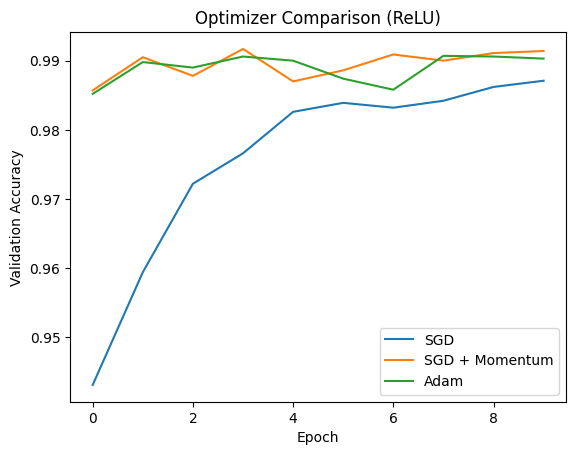

In [27]:
plt.plot(sgd_val_acc, label="SGD")
plt.plot(mom_val_acc, label="SGD + Momentum")
plt.plot(adam_val_acc, label="Adam")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.title("Optimizer Comparison (ReLU)")
plt.show()


MLP Model

In [28]:
class MLP(nn.Module):
    def __init__(self, layers, use_bn=True, dropout=0.0):
        super().__init__()
        modules = []
        input_dim = 28 * 28

        for units in layers:
            modules.append(nn.Linear(input_dim, units))
            if use_bn:
                modules.append(nn.BatchNorm1d(units))
            modules.append(nn.ReLU())
            if dropout > 0:
                modules.append(nn.Dropout(dropout))
            input_dim = units

        modules.append(nn.Linear(input_dim, 10))
        self.net = nn.Sequential(*modules)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


#Task 3 – BN & Dropout Experiments

### Task 3: Batch Normalization and Dropout
- No BN and no Dropout
- Dropout = 0.1 without BN
- BN with Dropout = 0.25

Observation:
- BN improves stability and speed of training.
- Dropout reduces overfitting.


Without BN & Dropout

In [29]:
mlp1 = MLP([256], use_bn=False).to(device)
optimizer = optim.Adam(mlp1.parameters(), lr=0.001)

tr_acc_1, val_acc_1, tr_loss_1, val_loss_1 = train_model(mlp1, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2276, Train Acc: 0.9311 | Val Loss: 0.1066, Val Acc: 0.9693
Epoch [2/10] | Train Loss: 0.0930, Train Acc: 0.9713 | Val Loss: 0.0879, Val Acc: 0.9726
Epoch [3/10] | Train Loss: 0.0639, Train Acc: 0.9801 | Val Loss: 0.0787, Val Acc: 0.9763
Epoch [4/10] | Train Loss: 0.0500, Train Acc: 0.9842 | Val Loss: 0.0735, Val Acc: 0.9764
Epoch [5/10] | Train Loss: 0.0351, Train Acc: 0.9888 | Val Loss: 0.0696, Val Acc: 0.9779
Epoch [6/10] | Train Loss: 0.0298, Train Acc: 0.9902 | Val Loss: 0.0854, Val Acc: 0.9762
Epoch [7/10] | Train Loss: 0.0237, Train Acc: 0.9919 | Val Loss: 0.0862, Val Acc: 0.9784
Epoch [8/10] | Train Loss: 0.0208, Train Acc: 0.9930 | Val Loss: 0.0894, Val Acc: 0.9777
Epoch [9/10] | Train Loss: 0.0175, Train Acc: 0.9939 | Val Loss: 0.0830, Val Acc: 0.9800
Epoch [10/10] | Train Loss: 0.0173, Train Acc: 0.9940 | Val Loss: 0.0867, Val Acc: 0.9777


Without BN, Dropout = 0.1

In [30]:
mlp2 = MLP([256], use_bn=False, dropout=0.1).to(device)
optimizer = optim.Adam(mlp2.parameters(), lr=0.001)

tr_acc_2, val_acc_2, tr_loss_2, val_loss_2 =train_model(mlp2, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2381, Train Acc: 0.9291 | Val Loss: 0.1280, Val Acc: 0.9617
Epoch [2/10] | Train Loss: 0.1030, Train Acc: 0.9691 | Val Loss: 0.0866, Val Acc: 0.9719
Epoch [3/10] | Train Loss: 0.0758, Train Acc: 0.9763 | Val Loss: 0.0792, Val Acc: 0.9756
Epoch [4/10] | Train Loss: 0.0592, Train Acc: 0.9812 | Val Loss: 0.0723, Val Acc: 0.9770
Epoch [5/10] | Train Loss: 0.0490, Train Acc: 0.9844 | Val Loss: 0.0723, Val Acc: 0.9772
Epoch [6/10] | Train Loss: 0.0400, Train Acc: 0.9862 | Val Loss: 0.0810, Val Acc: 0.9762
Epoch [7/10] | Train Loss: 0.0358, Train Acc: 0.9881 | Val Loss: 0.0643, Val Acc: 0.9820
Epoch [8/10] | Train Loss: 0.0325, Train Acc: 0.9891 | Val Loss: 0.0762, Val Acc: 0.9779
Epoch [9/10] | Train Loss: 0.0282, Train Acc: 0.9905 | Val Loss: 0.0762, Val Acc: 0.9807
Epoch [10/10] | Train Loss: 0.0268, Train Acc: 0.9909 | Val Loss: 0.0802, Val Acc: 0.9793


With BN, Dropout = 0.25

In [31]:
mlp3 = MLP([256], use_bn=True, dropout=0.25).to(device)
optimizer = optim.Adam(mlp3.parameters(), lr=0.001)

tr_acc_3, val_acc_3, tr_loss_3, val_loss_3 =train_model(mlp3, optimizer, criterion, 10)


Epoch [1/10] | Train Loss: 0.2602, Train Acc: 0.9259 | Val Loss: 0.1246, Val Acc: 0.9620
Epoch [2/10] | Train Loss: 0.1348, Train Acc: 0.9599 | Val Loss: 0.0912, Val Acc: 0.9738
Epoch [3/10] | Train Loss: 0.1030, Train Acc: 0.9692 | Val Loss: 0.0758, Val Acc: 0.9761
Epoch [4/10] | Train Loss: 0.0861, Train Acc: 0.9737 | Val Loss: 0.0756, Val Acc: 0.9782
Epoch [5/10] | Train Loss: 0.0749, Train Acc: 0.9766 | Val Loss: 0.0711, Val Acc: 0.9790
Epoch [6/10] | Train Loss: 0.0643, Train Acc: 0.9790 | Val Loss: 0.0694, Val Acc: 0.9785
Epoch [7/10] | Train Loss: 0.0577, Train Acc: 0.9817 | Val Loss: 0.0699, Val Acc: 0.9791
Epoch [8/10] | Train Loss: 0.0527, Train Acc: 0.9832 | Val Loss: 0.0687, Val Acc: 0.9798
Epoch [9/10] | Train Loss: 0.0483, Train Acc: 0.9843 | Val Loss: 0.0644, Val Acc: 0.9799
Epoch [10/10] | Train Loss: 0.0437, Train Acc: 0.9860 | Val Loss: 0.0691, Val Acc: 0.9795


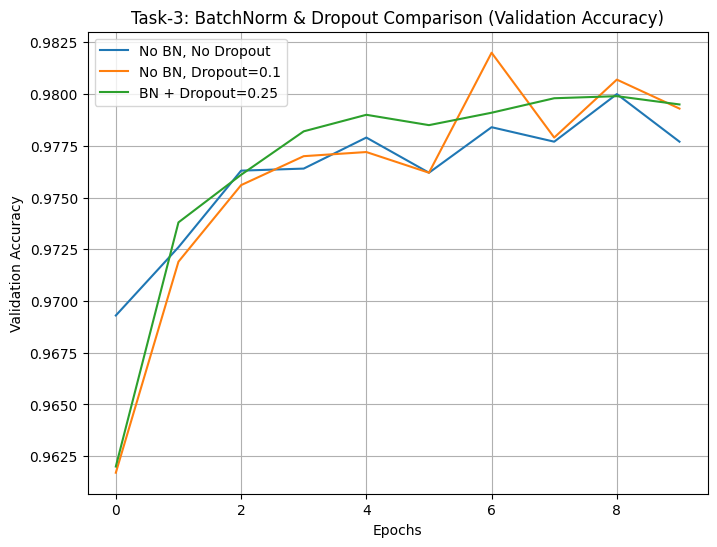

In [32]:
plt.figure(figsize=(8,6))

plt.plot(val_acc_1, label="No BN, No Dropout")
plt.plot(val_acc_2, label="No BN, Dropout=0.1")
plt.plot(val_acc_3, label="BN + Dropout=0.25")

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Task-3: BatchNorm & Dropout Comparison (Validation Accuracy)")
plt.legend()
plt.grid(True)
plt.show()


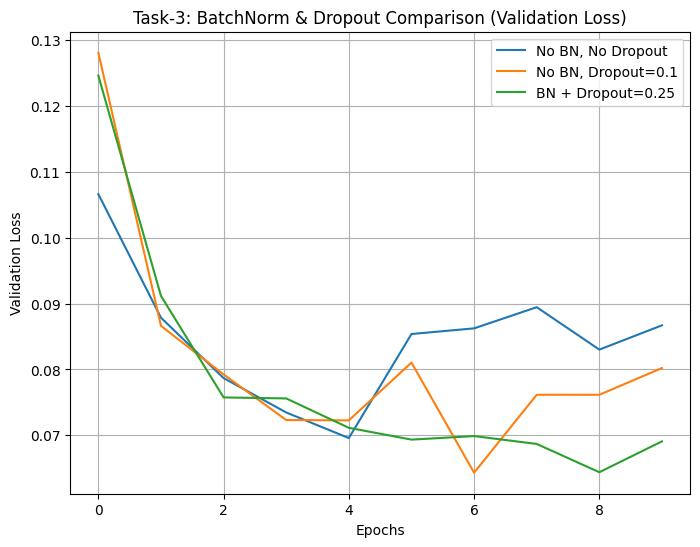

In [33]:
plt.figure(figsize=(8,6))

plt.plot(val_loss_1, label="No BN, No Dropout")
plt.plot(val_loss_2, label="No BN, Dropout=0.1")
plt.plot(val_loss_3, label="BN + Dropout=0.25")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Task-3: BatchNorm & Dropout Comparison (Validation Loss)")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
comparison_results = [
    # Task 1: Activation comparison
    ["Task-1", "Sigmoid", "SGD", 10, sig_val_acc[-1]],
    ["Task-1", "Tanh", "SGD", 10, tanh_val_acc[-1]],
    ["Task-1", "ReLU", "SGD", 10, relu_val_acc[-1]],

    # Task 2: Optimizer comparison (ReLU fixed)
    ["Task-2", "ReLU", "SGD", 10, sgd_val_acc[-1]],
    ["Task-2", "ReLU", "SGD + Momentum", 10, mom_val_acc[-1]],
    ["Task-2", "ReLU", "Adam", 10, adam_val_acc[-1]],

    # Task 3: BN & Dropout comparison (MLP)
    ["Task-3", "ReLU", "Adam", 10, val_acc_1[-1]],
    ["Task-3", "ReLU", "Adam", 10, val_acc_2[-1]],
    ["Task-3", "ReLU", "Adam", 10, val_acc_3[-1]],
]


In [35]:
import pandas as pd

df = pd.DataFrame(
    comparison_results,
    columns=[
        "Task",
        "Activation",
        "Optimizer",
        "Epochs",
        "Final_Val_Acc"
    ]
)

print(df.to_string(index=False))



  Task Activation      Optimizer  Epochs  Final_Val_Acc
Task-1    Sigmoid            SGD      10         0.9143
Task-1       Tanh            SGD      10         0.9820
Task-1       ReLU            SGD      10         0.9895
Task-2       ReLU            SGD      10         0.9871
Task-2       ReLU SGD + Momentum      10         0.9914
Task-2       ReLU           Adam      10         0.9903
Task-3       ReLU           Adam      10         0.9777
Task-3       ReLU           Adam      10         0.9793
Task-3       ReLU           Adam      10         0.9795


In [36]:
cnn1 = CNN(activation=nn.ReLU, dropout=0.25).to(device)
optimizer = optim.Adam(cnn1.parameters(), lr=0.001)

cnn_tr_acc, cnn_val_acc, cnn_tr_loss, cnn_val_loss = train_model(
    cnn1, optimizer, criterion, epochs=10
)



Epoch [1/10] | Train Loss: 0.1246, Train Acc: 0.9628 | Val Loss: 0.0442, Val Acc: 0.9859
Epoch [2/10] | Train Loss: 0.0424, Train Acc: 0.9865 | Val Loss: 0.0373, Val Acc: 0.9884
Epoch [3/10] | Train Loss: 0.0291, Train Acc: 0.9909 | Val Loss: 0.0326, Val Acc: 0.9889
Epoch [4/10] | Train Loss: 0.0197, Train Acc: 0.9935 | Val Loss: 0.0411, Val Acc: 0.9882
Epoch [5/10] | Train Loss: 0.0159, Train Acc: 0.9949 | Val Loss: 0.0427, Val Acc: 0.9888
Epoch [6/10] | Train Loss: 0.0134, Train Acc: 0.9955 | Val Loss: 0.0349, Val Acc: 0.9897
Epoch [7/10] | Train Loss: 0.0107, Train Acc: 0.9964 | Val Loss: 0.0373, Val Acc: 0.9908
Epoch [8/10] | Train Loss: 0.0105, Train Acc: 0.9967 | Val Loss: 0.0398, Val Acc: 0.9895
Epoch [9/10] | Train Loss: 0.0078, Train Acc: 0.9974 | Val Loss: 0.0445, Val Acc: 0.9890
Epoch [10/10] | Train Loss: 0.0085, Train Acc: 0.9971 | Val Loss: 0.0393, Val Acc: 0.9910


In [37]:
mlp1 = MLP(layers=[512, 256, 128], use_bn=True, dropout=0.0).to(device)
optimizer = optim.SGD(mlp1.parameters(), lr=0.01)

mlp1_tr_acc, mlp1_val_acc, mlp1_tr_loss, mlp1_val_loss = train_model(
    mlp1, optimizer, criterion, epochs=20
)



Epoch [1/20] | Train Loss: 0.4101, Train Acc: 0.9062 | Val Loss: 0.1535, Val Acc: 0.9601
Epoch [2/20] | Train Loss: 0.1466, Train Acc: 0.9617 | Val Loss: 0.1040, Val Acc: 0.9726
Epoch [3/20] | Train Loss: 0.0956, Train Acc: 0.9749 | Val Loss: 0.0859, Val Acc: 0.9753
Epoch [4/20] | Train Loss: 0.0695, Train Acc: 0.9821 | Val Loss: 0.0730, Val Acc: 0.9793
Epoch [5/20] | Train Loss: 0.0542, Train Acc: 0.9862 | Val Loss: 0.0673, Val Acc: 0.9800
Epoch [6/20] | Train Loss: 0.0420, Train Acc: 0.9900 | Val Loss: 0.0673, Val Acc: 0.9781
Epoch [7/20] | Train Loss: 0.0334, Train Acc: 0.9923 | Val Loss: 0.0638, Val Acc: 0.9803
Epoch [8/20] | Train Loss: 0.0277, Train Acc: 0.9942 | Val Loss: 0.0609, Val Acc: 0.9809
Epoch [9/20] | Train Loss: 0.0216, Train Acc: 0.9959 | Val Loss: 0.0609, Val Acc: 0.9808
Epoch [10/20] | Train Loss: 0.0183, Train Acc: 0.9970 | Val Loss: 0.0591, Val Acc: 0.9819
Epoch [11/20] | Train Loss: 0.0156, Train Acc: 0.9972 | Val Loss: 0.0618, Val Acc: 0.9807
Epoch [12/20] | Tra

In [38]:
mlp2 = MLP(layers=[256], use_bn=True, dropout=0.0).to(device)
optimizer = optim.Adam(mlp2.parameters(), lr=0.001)

mlp2_tr_acc, mlp2_val_acc, mlp2_tr_loss, mlp2_val_loss = train_model(
    mlp2, optimizer, criterion, epochs=15
)




Epoch [1/15] | Train Loss: 0.2262, Train Acc: 0.9362 | Val Loss: 0.1102, Val Acc: 0.9688
Epoch [2/15] | Train Loss: 0.1019, Train Acc: 0.9706 | Val Loss: 0.0843, Val Acc: 0.9749
Epoch [3/15] | Train Loss: 0.0701, Train Acc: 0.9797 | Val Loss: 0.0674, Val Acc: 0.9799
Epoch [4/15] | Train Loss: 0.0518, Train Acc: 0.9842 | Val Loss: 0.0718, Val Acc: 0.9766
Epoch [5/15] | Train Loss: 0.0407, Train Acc: 0.9881 | Val Loss: 0.0713, Val Acc: 0.9770
Epoch [6/15] | Train Loss: 0.0332, Train Acc: 0.9902 | Val Loss: 0.0663, Val Acc: 0.9787
Epoch [7/15] | Train Loss: 0.0278, Train Acc: 0.9913 | Val Loss: 0.0719, Val Acc: 0.9777
Epoch [8/15] | Train Loss: 0.0235, Train Acc: 0.9928 | Val Loss: 0.0735, Val Acc: 0.9779
Epoch [9/15] | Train Loss: 0.0198, Train Acc: 0.9940 | Val Loss: 0.0686, Val Acc: 0.9799
Epoch [10/15] | Train Loss: 0.0166, Train Acc: 0.9948 | Val Loss: 0.0693, Val Acc: 0.9801
Epoch [11/15] | Train Loss: 0.0163, Train Acc: 0.9950 | Val Loss: 0.0660, Val Acc: 0.9813
Epoch [12/15] | Tra

In [39]:
results = []


In [40]:
results.append([
    "CNN-1", 128, "Adam", 10,
    cnn_val_acc[-1],
    cnn_tr_acc, cnn_val_acc,
    cnn_tr_loss, cnn_val_loss
])

In [41]:

results.append([
    "MLP-1", "512-256-128", "SGD", 20,
    mlp1_val_acc[-1],
    mlp1_tr_acc, mlp1_val_acc,
    mlp1_tr_loss, mlp1_val_loss
])

In [42]:
results.append([
    "MLP-2", 256, "Adam", 15,
    mlp2_val_acc[-1],
    mlp2_tr_acc, mlp2_val_acc,
    mlp2_tr_loss, mlp2_val_loss
])

In [43]:
import pandas as pd

df = pd.DataFrame(
    results,
    columns=[
        "Model", "FC layer", "Optimizer", "Epochs",
        "Accuracy",
        "train_acc", "val_acc",
        "train_loss", "val_loss"
    ]
)

df["Accuracy"] = df["Accuracy"].round(4)

print(df[["Model", "FC layer", "Optimizer", "Epochs", "Accuracy"]].to_string(index=False))


Model    FC layer Optimizer  Epochs  Accuracy
CNN-1         128      Adam      10    0.9910
MLP-1 512-256-128       SGD      20    0.9829
MLP-2         256      Adam      15    0.9780


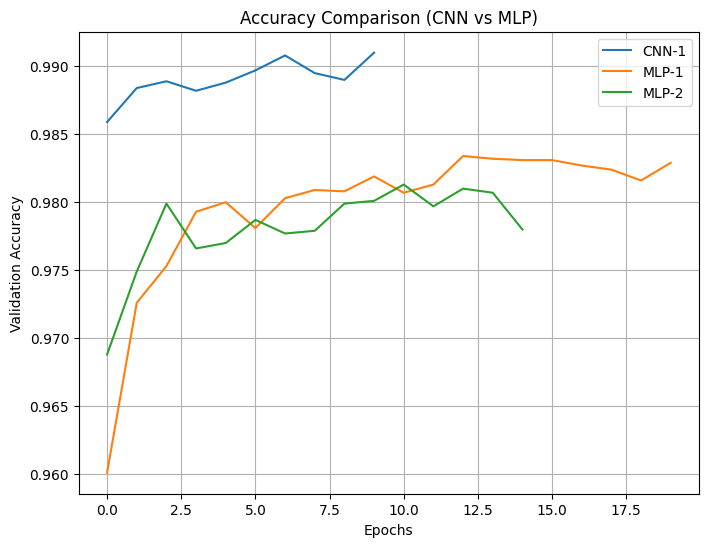

In [44]:
plt.figure(figsize=(8,6))

for r in results:
    plt.plot(r[6], label=r[0])   # r[6] = val_acc

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Accuracy Comparison (CNN vs MLP)")
plt.legend()
plt.grid(True)
plt.show()


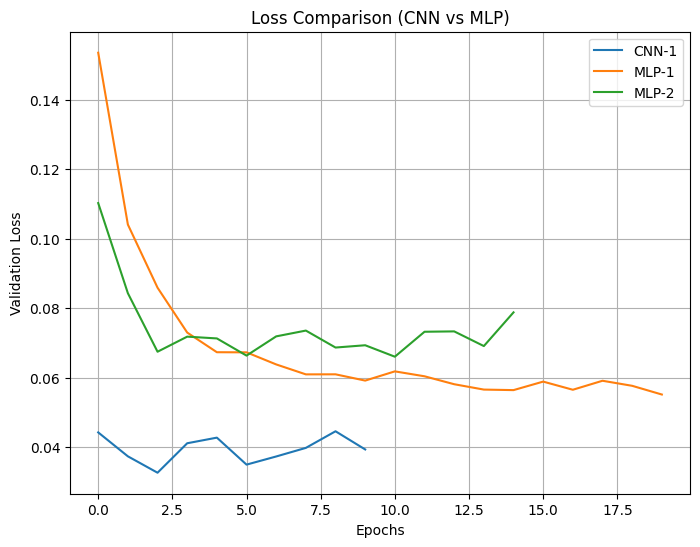

In [45]:
plt.figure(figsize=(8,6))

for r in results:
    plt.plot(r[8], label=r[0])   # r[8] = val_loss

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Loss Comparison (CNN vs MLP)")
plt.legend()
plt.grid(True)
plt.show()


## Conclusion
ReLU activation with Adam optimizer and Batch Normalization provides the best accuracy and fastest convergence.

## Author
Sweta Rana
AI Department, SVNIT Surat